In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/visoil/pytorch/default/1/finasl_model.pth
/kaggle/input/oilspill/Images/Images/frame_0562.jpg
/kaggle/input/oilspill/Images/Images/frame_0004.jpg
/kaggle/input/oilspill/Images/Images/frame_1167.jpg
/kaggle/input/oilspill/Images/Images/frame_1055.jpg
/kaggle/input/oilspill/Images/Images/frame_1493.jpg
/kaggle/input/oilspill/Images/Images/frame_1795.jpg
/kaggle/input/oilspill/Images/Images/frame_1114.jpg
/kaggle/input/oilspill/Images/Images/frame_0343.jpg
/kaggle/input/oilspill/Images/Images/frame_1028.jpg
/kaggle/input/oilspill/Images/Images/frame_0146.jpg
/kaggle/input/oilspill/Images/Images/frame_0231.jpg
/kaggle/input/oilspill/Images/Images/frame_1910.jpg
/kaggle/input/oilspill/Images/Images/frame_1717.jpg
/kaggle/input/oilspill/Images/Images/frame_1381.jpg
/kaggle/input/oilspill/Images/Images/frame_0823.jpg
/kaggle/input/oilspill/Images/Images/frame_2027.jpg
/kaggle/input/oilspill/Images/Images/frame_2037.jpg
/kaggle/input/oilspill/Images/Images/frame_0478.jpg
/kaggle/

In [4]:
!pip install numpy matplotlib torch torchvision opencv-python-headless pillow albumentations tqdm

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
size = (256, 256)
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = transforms.Resize(size)

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        img = self.transform(img)
        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = Image.open(self.masks_path[idx]).convert('L')
        mask = self.transform(mask)
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.le

In [8]:
def resize_images(images, masks, max_image_size=1500):
    shape = tf.shape(images)
    scale = (tf.reduce_max(shape) // max_image_size) + 1
    target_height, target_width = shape[-3] // scale, shape[-2] // scale
    images = tf.cast(images, tf.float32)
    masks = tf.cast(masks, tf.float32)
    if scale != 1:
        images = tf.image.resize(images, (target_height, target_width),  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        masks = tf.image.resize(masks, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        return (images, masks)

In [9]:
X = sorted(glob.glob('/kaggle/input/oilspill/Images/Images/*'))
Y = sorted(glob.glob('/kaggle/input/thresholded/Thresholded/*'))
len(X)
len(Y)

2077

In [10]:
import numpy as np
import glob

# Ensure X and Y are the same length
assert len(X) == len(Y), "The number of images and masks must be equal."

# Convert to NumPy arrays for advanced indexing
X = np.array(X)
Y = np.array(Y)

# Define split ratios
train_size = 0.7  # 70% for training
valid_size = 0.2  # 20% for validation
test_size = 0.1   # 10% for testing

# Shuffle the dataset
np.random.seed(42)  # For reproducibility
indices = np.random.permutation(len(X))

# Compute split indices
train_end = int(len(X) * train_size)
valid_end = train_end + int(len(X) * valid_size)

# Split the data
train_indices = indices[:train_end]
valid_indices = indices[train_end:valid_end]
test_indices = indices[valid_end:]

train_X, train_Y = X[train_indices], Y[train_indices]
valid_X, valid_Y = X[valid_indices], Y[valid_indices]
test_X, test_Y = X[test_indices], Y[test_indices]

# Print the sizes of each split
print(f"Training set: {len(train_X)} samples")
print(f"Validation set: {len(valid_X)} samples")
print(f"Test set: {len(test_X)} samples")


Training set: 1453 samples
Validation set: 415 samples
Test set: 209 samples


In [11]:
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np

class LoadData(Dataset):
    def __init__(self, images_path, masks_path, size=(256, 256)):
        super().__init__()
        self.images_path = images_path
        self.masks_path = masks_path
        self.size = size
        self.transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor()
        ])

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx]).convert("RGB")
        img = self.transform(img)

        mask = Image.open(self.masks_path[idx]).convert("L")
        mask = self.transform(mask)

        return img, mask
    
    def __len__(self):
        return len(self.images_path)


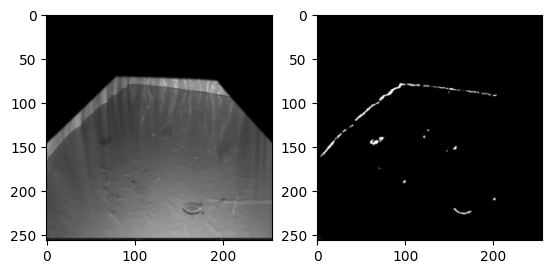

In [12]:
train_dataset = LoadData(train_X, train_Y)
valid_dataset = LoadData(valid_X, valid_Y)
test_dataset = LoadData(test_X, test_Y)
img, mask = train_dataset[5]
f, axarr = plt.subplots(1,2)
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))

In [13]:
import torch.nn as nn

class conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, images):
        x = self.conv1(images)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x


In [14]:
class encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = conv(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2,2))
    def forward(self, images):
        x = self.conv(images)
        p = self.pool(x)
        return x, p
class decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        self.conv = conv(out_channels * 2, out_channels)
    def forward(self, images, prev):
        x = self.upconv(images)
        x = torch.cat([x, prev], axis=1)
        x = self.conv(x)
        return x

In [15]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder(3, 64)
        self.e2 = encoder(64, 128)
        self.e3 = encoder(128, 256)
        self.e4 = encoder(256, 512)

        self.b = conv(512, 1024)

        self.d1 = decoder(1024, 512)
        self.d2 = decoder(512, 256)
        self.d3 = decoder(256, 128)
        self.d4 = decoder(128, 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, images):
        x1, p1 = self.e1(images)
        x2, p2 = self.e2(p1)
        x3, p3 = self.e3(p2)
        x4, p4 = self.e4(p3)

        b = self.b(p4)
        
        d1 = self.d1(b, x4)
        d2 = self.d2(d1, x3)
        d3 = self.d3(d2, x2)
        d4 = self.d4(d3, x1)

        output_mask = self.output(d4)
        output_mask = torch.sigmoid(output_mask)

        return output_mask

In [16]:
batch_size = 8
num_epochs = 30
lr = 1e-4
checkpoint_path = "./checkpoint.pth"

In [17]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
)

test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
)

In [18]:
device = torch.device('cuda')
model = UNet()
model = model.to(device)

In [19]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        dice_loss = 1 - dice_score
        loss = torch.nn.BCELoss()
        BCE = loss(inputs, targets)
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = DiceBCELoss()

Epoch 1/30


Validation loss improved from inf to 1.1647. Saving checkpoint...
	Train Loss: 1.246 | Val. Loss: 1.165 | Time: 57.82s
Epoch 2/30


Validation loss improved from 1.1647 to 1.0759. Saving checkpoint...
	Train Loss: 1.117 | Val. Loss: 1.076 | Time: 57.16s
Epoch 3/30


Validation loss improved from 1.0759 to 1.0021. Saving checkpoint...
	Train Loss: 1.034 | Val. Loss: 1.002 | Time: 56.99s
Epoch 4/30


Validation loss improved from 1.0021 to 0.9046. Saving checkpoint...
	Train Loss: 0.945 | Val. Loss: 0.905 | Time: 57.00s
Epoch 5/30


Validation loss improved from 0.9046 to 0.8019. Saving checkpoint...
	Train Loss: 0.843 | Val. Loss: 0.802 | Time: 56.98s
Epoch 6/30


Validation loss improved from 0.8019 to 0.6536. Saving checkpoint...
	Train Loss: 0.716 | Val. Loss: 0.654 | Time: 56.98s
Epoch 7/30


Validation loss improved from 0.6536 to 0.5216. Saving checkpoint...
	Train Loss: 0.572 | Val. Loss: 0.522 | Time: 56.96s
Epoch 8/30


Validation loss improved from 0.5216 to 0.4214. Saving checkpoint...
	Train Loss: 0.454 | Val. Loss: 0.421 | Time: 57.00s
Epoch 9/30


Validation loss improved from 0.4214 to 0.3533. Saving checkpoint...
	Train Loss: 0.371 | Val. Loss: 0.353 | Time: 56.93s
Epoch 10/30


Validation loss improved from 0.3533 to 0.3156. Saving checkpoint...
	Train Loss: 0.322 | Val. Loss: 0.316 | Time: 57.02s
Epoch 11/30


Validation loss improved from 0.3156 to 0.2908. Saving checkpoint...
	Train Loss: 0.292 | Val. Loss: 0.291 | Time: 56.96s
Epoch 12/30


Validation loss improved from 0.2908 to 0.2738. Saving checkpoint...
	Train Loss: 0.271 | Val. Loss: 0.274 | Time: 57.01s
Epoch 13/30


Validation loss improved from 0.2738 to 0.2583. Saving checkpoint...
	Train Loss: 0.257 | Val. Loss: 0.258 | Time: 56.93s
Epoch 14/30


Validation loss improved from 0.2583 to 0.2525. Saving checkpoint...
	Train Loss: 0.250 | Val. Loss: 0.252 | Time: 56.97s
Epoch 15/30


Validation loss improved from 0.2525 to 0.2453. Saving checkpoint...
	Train Loss: 0.240 | Val. Loss: 0.245 | Time: 56.98s
Epoch 16/30


Validation loss improved from 0.2453 to 0.2441. Saving checkpoint...
	Train Loss: 0.235 | Val. Loss: 0.244 | Time: 57.03s
Epoch 17/30


Validation loss improved from 0.2441 to 0.2365. Saving checkpoint...
	Train Loss: 0.231 | Val. Loss: 0.236 | Time: 57.04s
Epoch 18/30


Validation loss improved from 0.2365 to 0.2338. Saving checkpoint...
	Train Loss: 0.226 | Val. Loss: 0.234 | Time: 56.98s
Epoch 19/30


Validation loss improved from 0.2338 to 0.2324. Saving checkpoint...
	Train Loss: 0.223 | Val. Loss: 0.232 | Time: 56.98s
Epoch 20/30


Validation loss improved from 0.2324 to 0.2312. Saving checkpoint...
	Train Loss: 0.221 | Val. Loss: 0.231 | Time: 56.99s
Epoch 21/30


Validation loss improved from 0.2312 to 0.2299. Saving checkpoint...
	Train Loss: 0.219 | Val. Loss: 0.230 | Time: 57.01s
Epoch 22/30


Validation loss improved from 0.2299 to 0.2278. Saving checkpoint...
	Train Loss: 0.216 | Val. Loss: 0.228 | Time: 57.01s
Epoch 23/30


	Train Loss: 0.215 | Val. Loss: 0.232 | Time: 56.70s
Epoch 24/30


Validation loss improved from 0.2278 to 0.2249. Saving checkpoint...
	Train Loss: 0.214 | Val. Loss: 0.225 | Time: 57.06s
Epoch 25/30


Validation loss improved from 0.2249 to 0.2239. Saving checkpoint...
	Train Loss: 0.213 | Val. Loss: 0.224 | Time: 57.04s
Epoch 26/30


Validation loss improved from 0.2239 to 0.2237. Saving checkpoint...
	Train Loss: 0.212 | Val. Loss: 0.224 | Time: 57.04s
Epoch 27/30


	Train Loss: 0.212 | Val. Loss: 0.224 | Time: 56.76s
Epoch 28/30


Validation loss improved from 0.2237 to 0.2221. Saving checkpoint...
	Train Loss: 0.209 | Val. Loss: 0.222 | Time: 57.03s
Epoch 29/30


Validation loss improved from 0.2221 to 0.2221. Saving checkpoint...
	Train Loss: 0.210 | Val. Loss: 0.222 | Time: 57.03s
Epoch 30/30


Validation loss improved from 0.2221 to 0.2198. Saving checkpoint...
	Train Loss: 0.208 | Val. Loss: 0.220 | Time: 57.03s


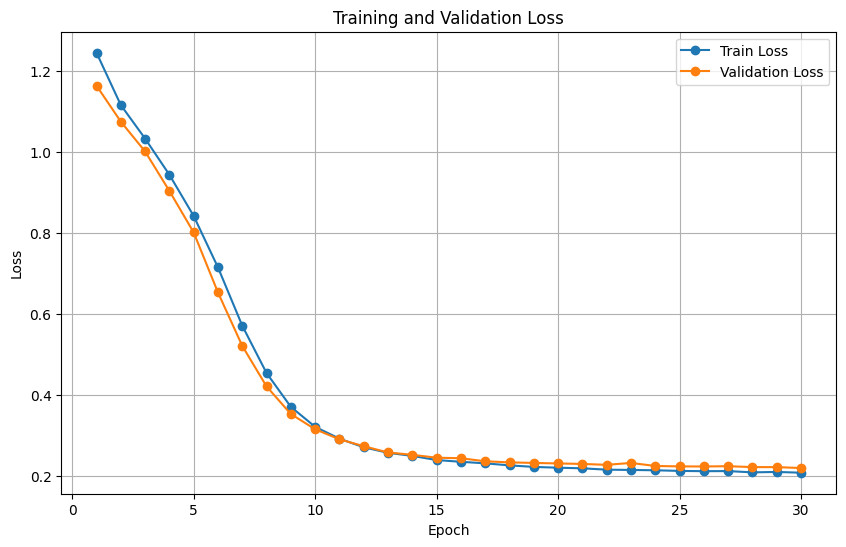

In [19]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

def train_model(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    progress_bar = tqdm(loader, desc="Training", leave=False)
    for x, y in progress_bar:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        progress_bar.set_postfix({"Batch Loss": loss.item()})
    
    epoch_loss = epoch_loss / len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    progress_bar = tqdm(loader, desc="Validating", leave=False)
    with torch.no_grad():
        for x, y in progress_bar:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()
            
            progress_bar.set_postfix({"Batch Loss": loss.item()})
    
    epoch_loss = epoch_loss / len(loader)
    return epoch_loss

train_losses = []
valid_losses = []
best_valid_loss = float("inf")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    start_time = time.time()

    train_loss = train_model(model, train_loader, optimizer, loss_fn, device)
    valid_loss = evaluate(model, valid_loader, loss_fn, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)        
        
    if valid_loss < best_valid_loss:
        print(f"Validation loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint...")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    end_time = time.time()
    print(f"\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f} | Time: {end_time - start_time:.2f}s")

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs + 1), valid_losses, label="Validation Loss", marker="o")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


In [24]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

# Define metrics
def compute_metrics(y_pred, y_true, threshold=0.5):
    """
    Compute accuracy, Dice coefficient, and IoU.
    """
    y_pred_bin = (y_pred > threshold).float()
    accuracy = (y_pred_bin == y_true).float().mean().item()
    
    intersection = (y_pred_bin * y_true).sum(dim=(1, 2, 3))
    union = (y_pred_bin + y_true).sum(dim=(1, 2, 3)) - intersection
    dice = (2 * intersection) / ((y_pred_bin.sum(dim=(1, 2, 3)) + y_true.sum(dim=(1, 2, 3))) + 1e-6)
    iou = intersection / (union + 1e-6)
    
    return accuracy, dice.mean().item(), iou.mean().item()

def evaluate_with_metrics(model, loader, loss_fn, device):
    epoch_loss = 0.0
    total_accuracy = 0.0
    total_dice = 0.0
    total_iou = 0.0
    total_batches = 0

    model.eval()
    progress_bar = tqdm(loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for x, y in progress_bar:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()
            
            accuracy, dice, iou = compute_metrics(y_pred, y)
            total_accuracy += accuracy
            total_dice += dice
            total_iou += iou
            total_batches += 1

            progress_bar.set_postfix({"Batch Loss": loss.item()})
    
    # Calculate average metrics
    avg_loss = epoch_loss / len(loader)
    avg_accuracy = total_accuracy / total_batches
    avg_dice = total_dice / total_batches
    avg_iou = total_iou / total_batches

    return avg_loss, avg_accuracy, avg_dice, avg_iou

# Evaluation on the test set
print("\nEvaluating on the Test Set...")
test_loss, test_accuracy, test_dice, test_iou = evaluate_with_metrics(model, test_loader, loss_fn, device)

print("\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Dice Coefficient: {test_dice:.4f}")
print(f"Test IoU: {test_iou:.4f}")


Evaluating on the Test Set...



Test Results:
Test Loss: 0.2198
Test Accuracy: 0.9796
Test Dice Coefficient: 0.7404
Test IoU: 0.6028


In [25]:
# Save the final model
final_model_path = "/kaggle/working/finasl_model.pth"
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")

Final model saved to /kaggle/working/finasl_model.pth


In [26]:
# Load the model state dictionary only
model = UNet()  # Replace with your actual model class
state_dict = torch.load(final_model_path, weights_only=True)  # Explicitly set weights_only=True
model.load_state_dict(state_dict)
model.to(device)
model.eval()

print("Model loaded successfully.")


Model loaded successfully.


<Figure size 3000x800 with 0 Axes>

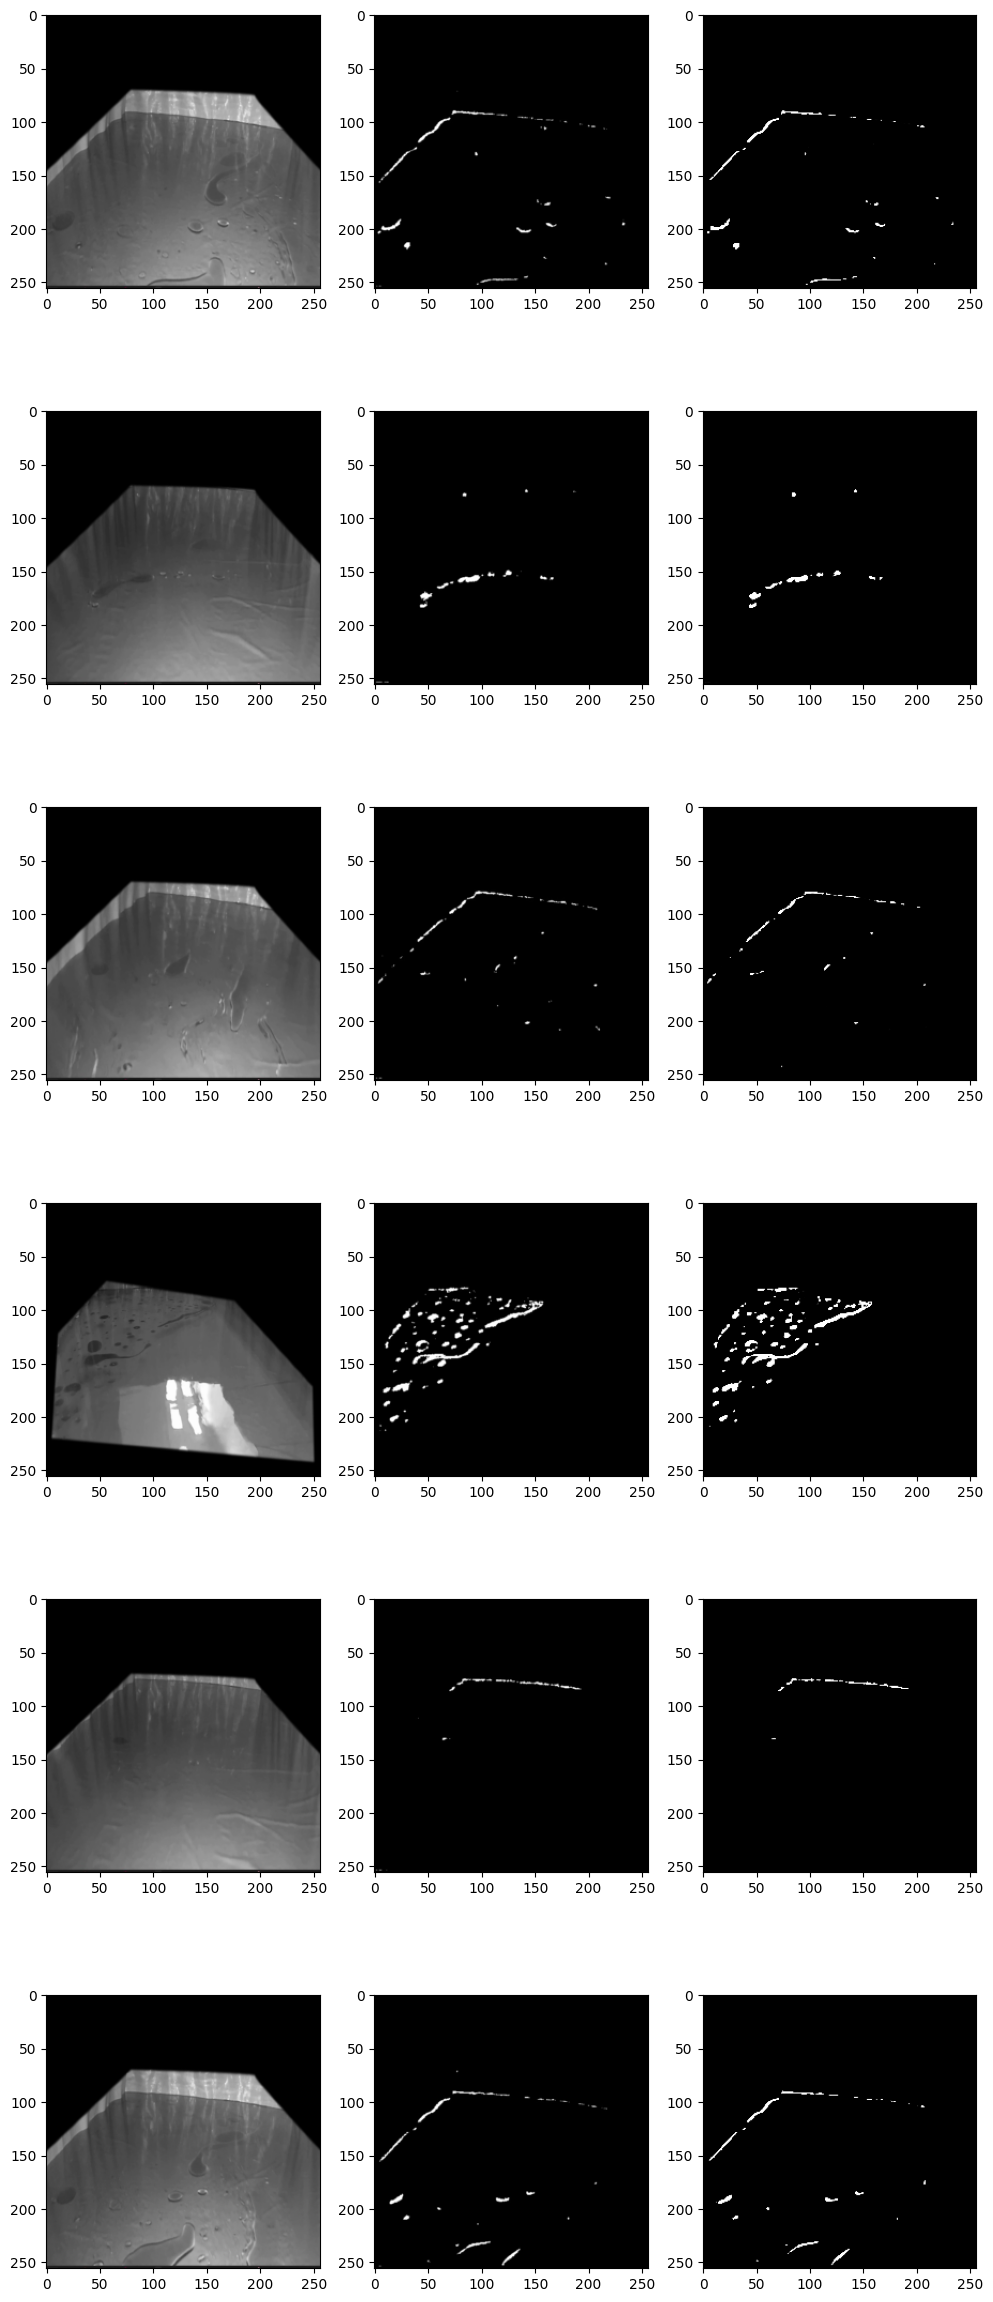

In [27]:
transform = transforms.ToPILImage()
pred = []

for x, y in valid_loader:
    # Convert tensor images to PIL images for display
    image0 = transform(x[0])
    image1 = transform(x[1])
    image2 = transform(x[2])
    image3 = transform(x[3])
    image4 = transform(x[4])
    image5 = transform(x[5])

    # Move data to the device
    x = x.to(device, dtype=torch.float32)
    y = y.to(device, dtype=torch.float32)

    # Perform prediction
    y_pred = model(x)  # Replace `m` with `model` (or the appropriate variable)
    img = y_pred.cpu().detach().numpy()

    # Set up the plots
    plt.figure(figsize=(30, 8))
    f, axarr = plt.subplots(6, 3)
    f.set_size_inches(12, 30, forward=True)

    # Display images and corresponding predictions
    axarr[0, 0].imshow(image0)
    axarr[0, 1].imshow(np.squeeze(y.cpu().detach().numpy())[0], cmap='gray')
    axarr[0, 2].imshow(np.squeeze(img)[0], cmap='gray')

    axarr[1, 0].imshow(image1)
    axarr[1, 1].imshow(np.squeeze(y.cpu().detach().numpy())[1], cmap='gray')
    axarr[1, 2].imshow(np.squeeze(img)[1], cmap='gray')

    axarr[5, 0].imshow(image2)
    axarr[5, 1].imshow(np.squeeze(y.cpu().detach().numpy())[2], cmap='gray')
    axarr[5, 2].imshow(np.squeeze(img)[2], cmap='gray')

    axarr[2, 0].imshow(image3)
    axarr[2, 1].imshow(np.squeeze(y.cpu().detach().numpy())[3], cmap='gray')
    axarr[2, 2].imshow(np.squeeze(img)[3], cmap='gray')

    axarr[3, 0].imshow(image4)
    axarr[3, 1].imshow(np.squeeze(y.cpu().detach().numpy())[4], cmap='gray')
    axarr[3, 2].imshow(np.squeeze(img)[4], cmap='gray')

    axarr[4, 0].imshow(image5)
    axarr[4, 1].imshow(np.squeeze(y.cpu().detach().numpy())[5], cmap='gray')
    axarr[4, 2].imshow(np.squeeze(img)[5], cmap='gray')

    break  # Exit after processing the first batch


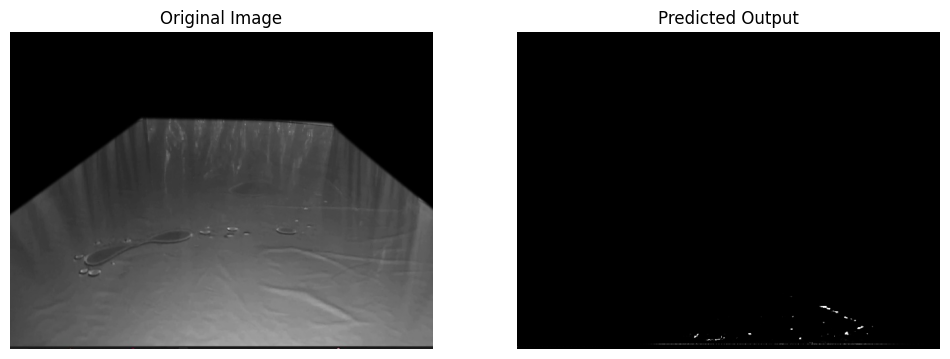

In [30]:
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Paths
image_path = r"/kaggle/input/oilspill/Images/Images/frame_0670.jpg"



# Image transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust normalization as per model training
])

# Load and preprocess the image
image = Image.open(image_path).convert("RGB")  # Convert to RGB if needed
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Perform prediction
with torch.no_grad():
    prediction = model(input_tensor)  # Forward pass
    pred_image = prediction.cpu().squeeze().numpy()  # Convert prediction to NumPy array

# Plot original image and prediction
plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

# Display predicted output
plt.subplot(1, 2, 2)
plt.title("Predicted Output")
plt.imshow(pred_image, cmap='gray')  # Display prediction as grayscale
plt.axis("off")

plt.show()


In [21]:
# Save the final model
final_model_path = "/kaggle/input/visoil/pytorch/default/1/finasl_model.pth"

In [22]:
# Load the model state dictionary only
model = UNet()  # Replace with your actual model class
state_dict = torch.load(final_model_path, weights_only=True)  # Explicitly set weights_only=True
model.load_state_dict(state_dict)
model.to(device)
model.eval()

print("Model loaded successfully.")


Model loaded successfully.


In [23]:
from tqdm import tqdm


In [24]:
def compute_metrics(y_pred, y_true, threshold=0.5):
    """
    Compute accuracy, Dice coefficient, and IoU for predictions.

    Args:
        y_pred (torch.Tensor): Predicted outputs from the model.
        y_true (torch.Tensor): Ground truth labels.
        threshold (float): Threshold for binary classification.

    Returns:
        tuple: accuracy, dice coefficient, and IoU.
    """
    y_pred_bin = (y_pred > threshold).float()  # Binarize predictions
    y_true_bin = (y_true > threshold).float()  # Ensure ground truth is binary

    # Accuracy
    correct = (y_pred_bin == y_true_bin).sum().item()
    total = y_true_bin.numel()
    accuracy = correct / total

    # Dice coefficient
    intersection = (y_pred_bin * y_true_bin).sum().item()
    dice = (2 * intersection) / (y_pred_bin.sum().item() + y_true_bin.sum().item() + 1e-8)

    # IoU
    union = (y_pred_bin + y_true_bin).sum().item() - intersection
    iou = intersection / (union + 1e-8)

    return accuracy, dice, iou


In [26]:
import cv2
import torch
import numpy as np
from torchvision.transforms import functional as TF

# Load the pre-trained U-Net model
final_model_path = "/kaggle/input/visoil/pytorch/default/1/finasl_model.pth"
model = UNet()  # Replace with your actual model class
state_dict = torch.load(final_model_path, map_location="cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(state_dict)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Open the video
video_path = "/kaggle/input/testset/clip_2.mp4"
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video writer
output_path = "/kaggle/working/predicted_clip_2.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Process each frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Preprocess frame
    original_frame = frame.copy()
    frame_resized = cv2.resize(frame, (256, 256))
    frame_tensor = TF.to_tensor(frame_resized).unsqueeze(0).to(device)
    
    # Predict using U-Net
    with torch.no_grad():
        pred = model(frame_tensor)
        pred = torch.sigmoid(pred)  # Assuming binary segmentation
        pred = pred.squeeze().cpu().numpy()
        
    # Post-process prediction
    pred_resized = cv2.resize((pred > 0.5).astype(np.uint8) * 255, (frame_width, frame_height))

    
    # Post-process prediction
    pred_resized = cv2.resize((pred > 0.5).astype(np.uint8) * 255, (frame_width, frame_height))
    pred_colored = cv2.applyColorMap(pred_resized, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original_frame, 0.6, pred_colored, 0.4, 0)
    
    # Write the frame to the output video
    out.write(overlay)

# Release resources
cap.release()
out.release()

print(f"Processed video saved to {output_path}")


/tmp/ipykernel_23/2426857889.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(final_model_path, map_location="cuda" if torch.cuda.is_available() e

Processed video saved to /kaggle/working/predicted_clip_2.mp4


/tmp/ipykernel_23/2040585324.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(final_model_path, map_location="cuda" if torch.cuda.is_available() 

RuntimeError: Error(s) in loading state_dict for UNet:
	Unexpected key(s) in state_dict: "e1.conv.conv1.weight", "e1.conv.conv1.bias", "e1.conv.bn1.weight", "e1.conv.bn1.bias", "e1.conv.bn1.running_mean", "e1.conv.bn1.running_var", "e1.conv.bn1.num_batches_tracked", "e1.conv.conv2.weight", "e1.conv.conv2.bias", "e1.conv.bn2.weight", "e1.conv.bn2.bias", "e1.conv.bn2.running_mean", "e1.conv.bn2.running_var", "e1.conv.bn2.num_batches_tracked", "e2.conv.conv1.weight", "e2.conv.conv1.bias", "e2.conv.bn1.weight", "e2.conv.bn1.bias", "e2.conv.bn1.running_mean", "e2.conv.bn1.running_var", "e2.conv.bn1.num_batches_tracked", "e2.conv.conv2.weight", "e2.conv.conv2.bias", "e2.conv.bn2.weight", "e2.conv.bn2.bias", "e2.conv.bn2.running_mean", "e2.conv.bn2.running_var", "e2.conv.bn2.num_batches_tracked", "e3.conv.conv1.weight", "e3.conv.conv1.bias", "e3.conv.bn1.weight", "e3.conv.bn1.bias", "e3.conv.bn1.running_mean", "e3.conv.bn1.running_var", "e3.conv.bn1.num_batches_tracked", "e3.conv.conv2.weight", "e3.conv.conv2.bias", "e3.conv.bn2.weight", "e3.conv.bn2.bias", "e3.conv.bn2.running_mean", "e3.conv.bn2.running_var", "e3.conv.bn2.num_batches_tracked", "e4.conv.conv1.weight", "e4.conv.conv1.bias", "e4.conv.bn1.weight", "e4.conv.bn1.bias", "e4.conv.bn1.running_mean", "e4.conv.bn1.running_var", "e4.conv.bn1.num_batches_tracked", "e4.conv.conv2.weight", "e4.conv.conv2.bias", "e4.conv.bn2.weight", "e4.conv.bn2.bias", "e4.conv.bn2.running_mean", "e4.conv.bn2.running_var", "e4.conv.bn2.num_batches_tracked", "b.conv1.weight", "b.conv1.bias", "b.bn1.weight", "b.bn1.bias", "b.bn1.running_mean", "b.bn1.running_var", "b.bn1.num_batches_tracked", "b.conv2.weight", "b.conv2.bias", "b.bn2.weight", "b.bn2.bias", "b.bn2.running_mean", "b.bn2.running_var", "b.bn2.num_batches_tracked", "d1.upconv.weight", "d1.upconv.bias", "d1.conv.conv1.weight", "d1.conv.conv1.bias", "d1.conv.bn1.weight", "d1.conv.bn1.bias", "d1.conv.bn1.running_mean", "d1.conv.bn1.running_var", "d1.conv.bn1.num_batches_tracked", "d1.conv.conv2.weight", "d1.conv.conv2.bias", "d1.conv.bn2.weight", "d1.conv.bn2.bias", "d1.conv.bn2.running_mean", "d1.conv.bn2.running_var", "d1.conv.bn2.num_batches_tracked", "d2.upconv.weight", "d2.upconv.bias", "d2.conv.conv1.weight", "d2.conv.conv1.bias", "d2.conv.bn1.weight", "d2.conv.bn1.bias", "d2.conv.bn1.running_mean", "d2.conv.bn1.running_var", "d2.conv.bn1.num_batches_tracked", "d2.conv.conv2.weight", "d2.conv.conv2.bias", "d2.conv.bn2.weight", "d2.conv.bn2.bias", "d2.conv.bn2.running_mean", "d2.conv.bn2.running_var", "d2.conv.bn2.num_batches_tracked", "d3.upconv.weight", "d3.upconv.bias", "d3.conv.conv1.weight", "d3.conv.conv1.bias", "d3.conv.bn1.weight", "d3.conv.bn1.bias", "d3.conv.bn1.running_mean", "d3.conv.bn1.running_var", "d3.conv.bn1.num_batches_tracked", "d3.conv.conv2.weight", "d3.conv.conv2.bias", "d3.conv.bn2.weight", "d3.conv.bn2.bias", "d3.conv.bn2.running_mean", "d3.conv.bn2.running_var", "d3.conv.bn2.num_batches_tracked", "d4.upconv.weight", "d4.upconv.bias", "d4.conv.conv1.weight", "d4.conv.conv1.bias", "d4.conv.bn1.weight", "d4.conv.bn1.bias", "d4.conv.bn1.running_mean", "d4.conv.bn1.running_var", "d4.conv.bn1.num_batches_tracked", "d4.conv.conv2.weight", "d4.conv.conv2.bias", "d4.conv.bn2.weight", "d4.conv.bn2.bias", "d4.conv.bn2.running_mean", "d4.conv.bn2.running_var", "d4.conv.bn2.num_batches_tracked", "output.weight", "output.bias". 